<a href="https://colab.research.google.com/github/YirenShen-07/Assignment6modifications/blob/main/Assignment6modifications.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #06
### The purpose of this project is to analyze and understand the factors affecting credit risk in German credit data using various explanatory visualization techniques. By employing Partial Dependency Plots (PDP), Accumulated Local Effects (ALE), Individual Conditional Expectation (ICE), and Feature Importance Analysis, I aim to explain how different features, particularly Age, Credit Amount, and Duration, influence the model's credit risk predictions.
### Yiren Shen

#### Include the button below. Change the link to the location in your github repository:

## DO:
* For a model and dataset of your choice, produce PDP, ICE, and ALE plots. Exploratory analysis of your dataset should be performed to determine the amount of correlation between features.  
* Provide a comprehensive explanation of your plots. Discuss any interesting findings that are shown in the plots. Discuss any differences you see in the PDP and ALE plots. Discuss your exploratory findings around correlation between features and the impact this has (if any) on your results.


In [49]:
# Please use this to connect your GitHub repository to your Google Colab notebook
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "Duke-AI-XAI" # Change to your repo name
git_path = 'https://github.com/AIPI-590-XAI/Duke-AI-XAI.git' #Change to your path
!git clone "{git_path}"

# Install dependencies from requirements.txt file
#!pip install -r "{os.path.join(repo_name,'requirements.txt')}" #Add if using requirements.txt

# Change working directory to location of notebook
notebook_dir = 'templates'
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "{path_to_notebook}"
%ls

rm: cannot remove './sample_data': No such file or directory
Cloning into 'Duke-AI-XAI'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 68 (delta 22), reused 49 (delta 12), pack-reused 0 (from 0)
Receiving objects: 100% (68/68), 6.59 MiB | 5.73 MiB/s, done.
Resolving deltas: 100% (22/22), done.
/content/Duke-AI-XAI/templates/Duke-AI-XAI/templates
template.ipynb


# Import dataset

In [50]:
!pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython

  Cloning https://github.com/MaximeJumelle/ALEPython.git (to revision dev) to /tmp/pip-install-nohjl16t/alepython_3d034b03e6d74d55b592a8312a990be3
  Running command git clone --filter=blob:none --quiet https://github.com/MaximeJumelle/ALEPython.git /tmp/pip-install-nohjl16t/alepython_3d034b03e6d74d55b592a8312a990be3
  Resolved https://github.com/MaximeJumelle/ALEPython.git to commit 286350ab674980a32270db2a0b5ccca1380312a7
  Preparing metadata (setup.py) ... done


In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.inspection import PartialDependenceDisplay
from alepython import ale_plot
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score

In [52]:
import csv
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The dataset for this project is German credit data:

In [53]:
df="/content/drive/MyDrive/german_credit_data.csv"
df=pd.read_csv(df)
df

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad
...,...,...,...,...,...,...,...,...,...,...,...
995,995,31,female,1,own,little,NaN,1736,12,furniture/equipment,good
996,996,40,male,3,own,little,little,3857,30,car,good
997,997,38,male,2,own,little,NaN,804,12,radio/TV,good
998,998,23,male,2,free,little,little,1845,45,radio/TV,bad


Numerical Features:

Age: The age of the credit applicant

Credit amount: The amount of credit requested

Duration: The duration of the credit in months

Job: The employment category of the applicant

Categorical Features:

Sex: The applicant's gender (male/female)

Housing: Type of housing (own/rent/free)

Saving accounts: Status of saving accounts (little/moderate/quite rich/rich/unknown)

Checking account: Status of checking accounts (little/moderate/rich/unknown)

Purpose: Purpose of the credit (car/furniture/radio/TV/education/business/etc.)

Target Variable:

Risk: Credit risk classification (good/bad)

# Data preprocessing and use of logistic regression models

* Classification and analysis of the German Credit Data dataset using logistic regression modeling with a focus on credit risk prediction.
* The purpose of this analysis is to evaluate the impact of individual features on credit risk and to predict potential credit risk.

In [54]:
# Print column names to check
print("Column names in the dataset:")
print(df.columns)

# Handle missing values - using correct column names
df['Saving accounts'] = df['Saving accounts'].fillna('unknown')
df['Checking account'] = df['Checking account'].fillna('unknown')

# Convert Risk to numeric
df['Risk'] = df['Risk'].map({'good': 1, 'bad': 0})

# One-hot encoding for categorical variables
categorical_cols = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
df = pd.get_dummies(df, columns=categorical_cols)

# Prepare features and target
X = df.drop(['Risk', 'Unnamed: 0'], axis=1)
y = df['Risk']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Logistic Regression model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

Column names in the dataset:
Index(['Unnamed: 0', 'Age', 'Sex', 'Job', 'Housing', 'Saving accounts',
       'Checking account', 'Credit amount', 'Duration', 'Purpose', 'Risk'],
      dtype='object')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000, random_state=42)

**Dataset column name checking**
The output column names identify all the features and target variables in the dataset:

The features include: 'Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration' and 'Purpose'.

Target variable: **'Risk'** for predicting credit risk.

# Correlations
Calculate and visualize between numerical features in a dataset

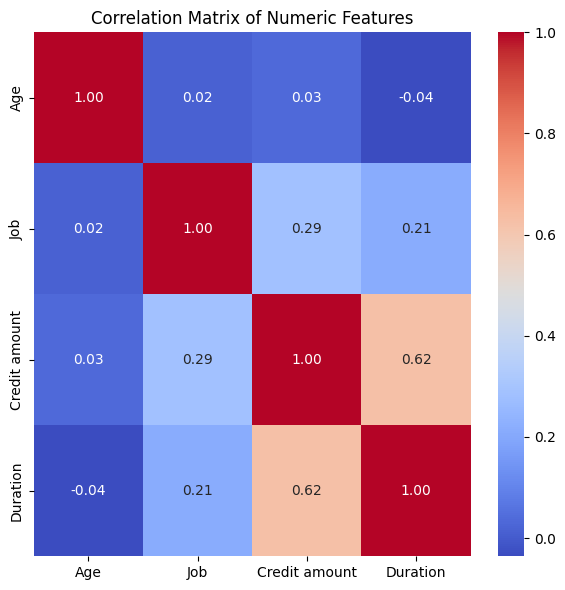

In [55]:
# Select only numeric columns for correlation calculation
numeric_cols = ['Age', 'Job', 'Credit amount', 'Duration']
plt.figure(figsize=(6, 6))

# Calculate the correlation matrix
correlation_matrix = df[numeric_cols].corr()

# Plot the heatmap for the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numeric Features')
plt.tight_layout()
plt.show()



*   The correlation between Credit amount and Duration is 0.62, which means that they have a moderate positive correlation. This indicates that the higher the credit amount, the longer the duration of the loan usually is.
*   The correlation between Job and Credit amount is 0.29 which means that there is a weak correlation between the two. This could mean that different types of jobs affect the amount of loan applied for, but are not the determining factor.
* Weak correlations between other characteristics such as Age and Credit amount (0.03), and Age and Duration (-0.04) suggest that these characteristics do not have a significant linear effect on each other.
* The moderate positive correlation between Credit amount and Duration may have a large impact on the model predictions, so I chose age, Credit amount and Duration



# Partial Dependence Plots (PDP)
* It shows how model predictions change as a result of a change in a feature, while other features remain constant.
* The PDP can help understand the impact of Age, Loan Amount, and Loan Duration on a customer's credit risk prediction.

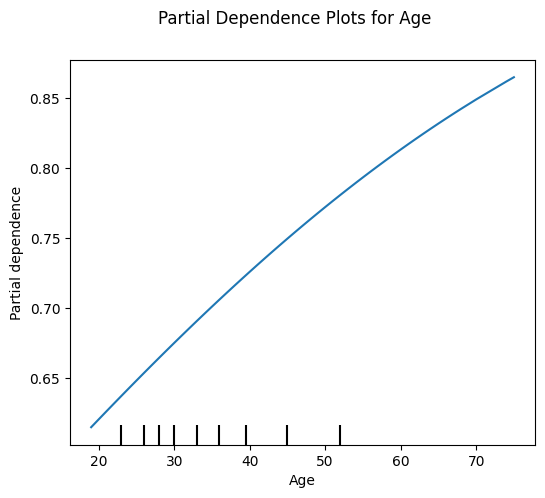

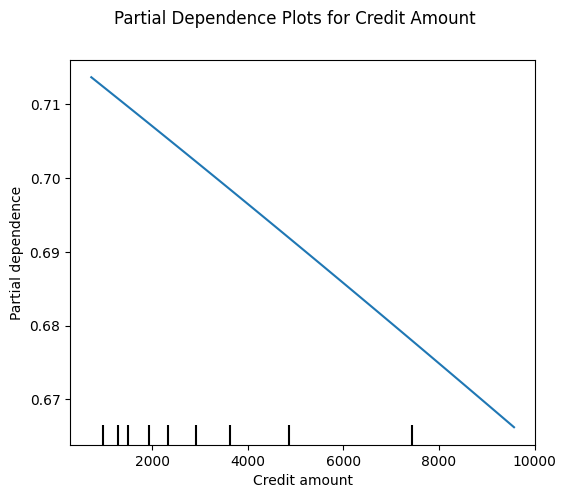

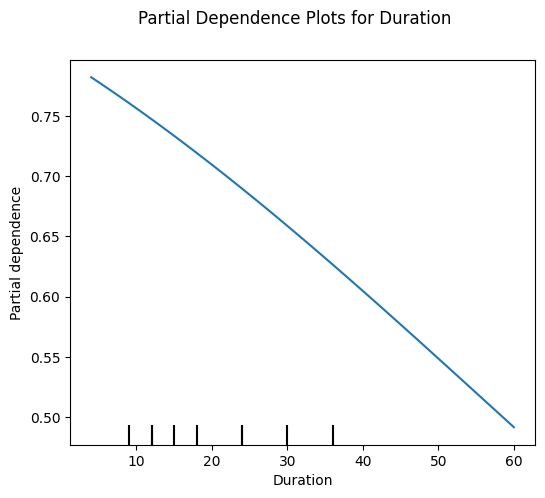

In [56]:
# Generate Partial Dependence Plots (PDP) for Age, Credit Amount, Duration
features = ['Age']
fig, ax = plt.subplots(figsize=(6, 5))
PartialDependenceDisplay.from_estimator(model, X_train, features, kind='average', ax=ax)
plt.suptitle('Partial Dependence Plots for Age')

features = ['Credit amount']
fig, ax = plt.subplots(figsize=(6, 5))
PartialDependenceDisplay.from_estimator(model, X_train, features, kind='average', ax=ax)
plt.suptitle('Partial Dependence Plots for Credit Amount')

features = ['Duration']
fig, ax = plt.subplots(figsize=(6, 5))
PartialDependenceDisplay.from_estimator(model, X_train, features, kind='average', ax=ax)
plt.suptitle('Partial Dependence Plots for Duration')

plt.show()

* Age has a monotonically increasing effect on partial dependence. As age increases, the partial dependence value increases, meaning that older customers are more likely to be predicted as low credit risk ('good').

* The PDP plot for Credit Amount shows a negative correlation. The partial dependence value decreases as the loan amount increases, indicating that the model is less likely to predict low credit risk at higher loan amounts.

* The PDP plot for Duration also shows a negative correlation. The longer the loan duration, the lower the partial dependence value, which implies that longer loan durations may increase the risk of default.

* **Comparison:** The three PDP plots help to explain the predictive trends of the model under different characteristics. Age is a positive factor (i.e., the probability of low risk increases with age), while Credit Amount and Duration are negative factors (i.e., higher loan amounts and longer loan durations increase risk).

# ICE Plots

* ICE Plot can show the effect of changes in specific eigenvalues for each sample on the model output. This is more nuanced than PDP because it reveals the individualized response of the model on different samples.
* In credit risk prediction, ICE Plot can help analyze the change in predicted risk for a particular customer under different loan amounts, loan terms, or age conditions. This helps you understand how the model reacts differently to different customers.

Text(0.5, 1.0, 'ICE Plot for Duration')

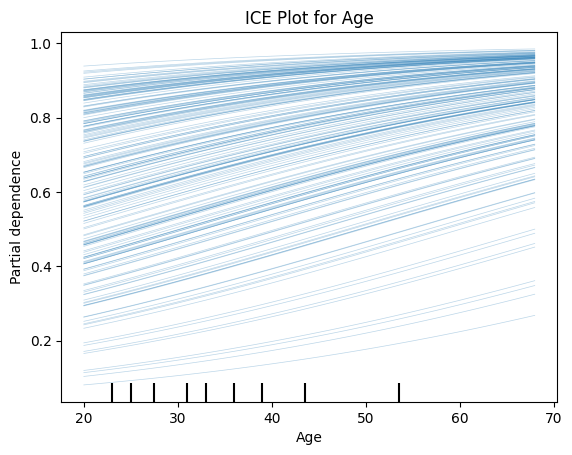

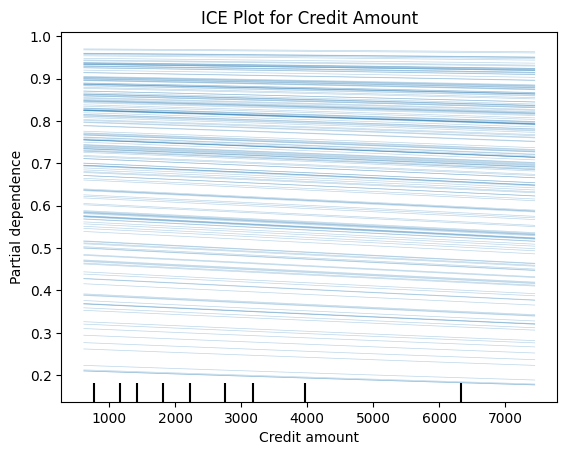

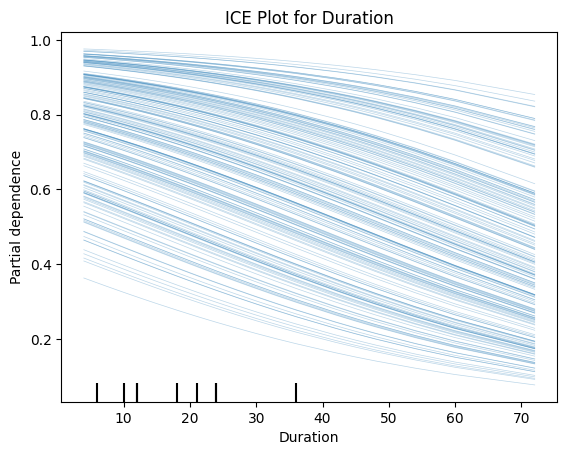

In [57]:
# Generate ICE plots
features = ['Age']
PartialDependenceDisplay.from_estimator(model, X_test, features, kind='individual')
plt.title('ICE Plot for Age')

features = ['Credit amount']
PartialDependenceDisplay.from_estimator(model, X_test, features, kind='individual')
plt.title('ICE Plot for Credit Amount')

features = ['Duration']
PartialDependenceDisplay.from_estimator(model, X_test, features, kind='individual')
plt.title('ICE Plot for Duration')

**Ice Plot for Age:**
* Across the samples, there is an overall upward trend in the predictions of the model as age increases. This is consistent with the results of the PDP, suggesting that higher age generally corresponds to lower credit risk.
* Age is an important characteristic, and higher age may be viewed by the model as a signal of increased financial stability, thereby reducing predicted credit risk.

**Ice Plot for Credit Amount:**
* As the loan amount increases, the model's predictions tend to decrease. This means that higher loan amounts increase credit risk.
* The probability of the model predicting a high risk increases with higher loan amounts. This may be due to the fact that a higher loan amount increases the repayment pressure on the customer, which leads to a higher risk of default.

**Ice Plot for Duration:**
* As the loan duration increases, the model's predictions show a decreasing trend, consistent with the results of the PDP. This means that the longer the loan duration, the higher the credit risk predicted by the model.
* Longer loan durations are generally seen as higher risk because the longer the duration, the more unstable the customer's financial position may be, thus increasing the credit risk.

**Comparison:** Duration is probably the most influential feature because of the large variation in its curve and the significant difference in response between samples, which implies that it contributes more to the model prediction.

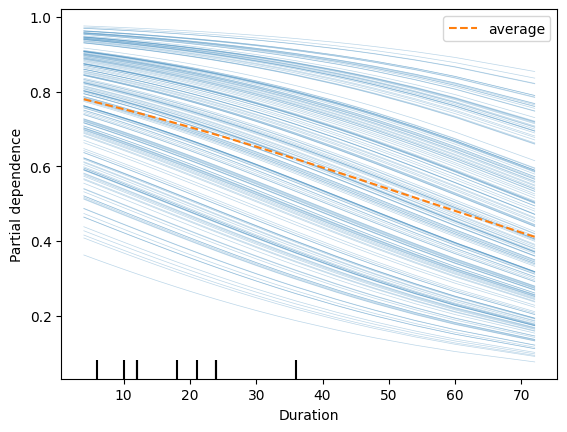

In [58]:
# Use PartialDependenceDisplay to generate Partial Dependence Plots (PDP) and Individual Conditional Expectation (ICE) plots
PartialDependenceDisplay.from_estimator(model, X_test, features, kind='both')

**Output:** The ICE curves for the majority of the samples (blue) follow the overall trend of the PDP (orange), implying that Duration is a relatively consistent feature that has a significant impact on model predictions.

# ALE plot
Unlike PDP, ALE Plot is better able to cope with covariance between features. whereas PDP is affected by correlation between features in its calculation, ALE Plot removes this effect through the accumulation of localized effects, allowing it to provide a more realistic interpretation of feature effects in credit risk analysis.

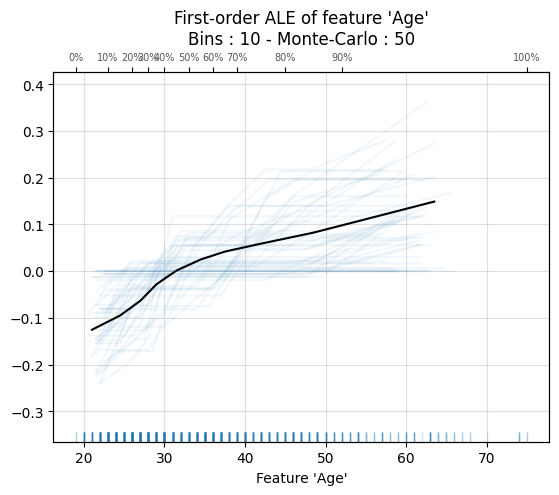

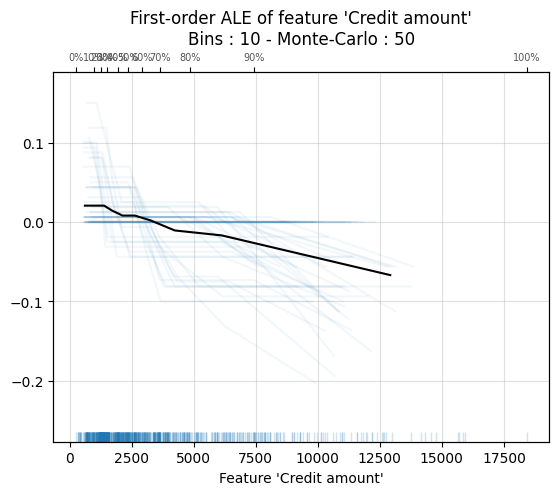

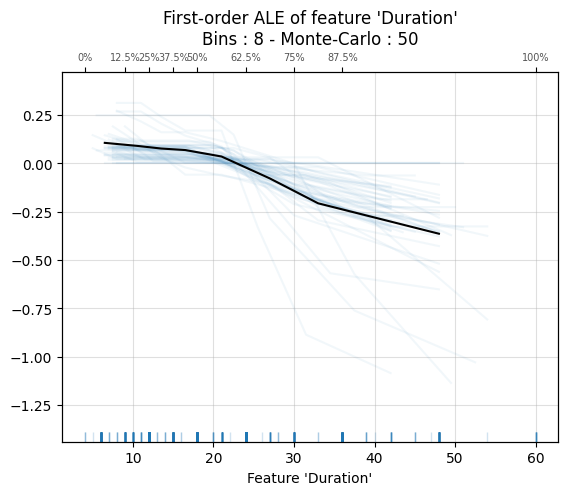

<Axes: title={'center': "First-order ALE of feature 'Duration'\nBins : 8 - Monte-Carlo : 50"}, xlabel="Feature 'Duration'">

In [59]:
# Generate ALE plots
ale_plot(model, X_train, 'Age', monte_carlo=True)
ale_plot(model, X_train, 'Credit amount', monte_carlo=True)
ale_plot(model, X_train, 'Duration', monte_carlo=True)

**ALE plot for Age**

As age increases, the ALE curve increases overall. This suggests that in the model, increasing age generally reduces credit risk, with the effect being especially pronounced after age 50+.

**ALE Plot of Credit Amount**

Overall trend: the ALE curve tends to decrease as the loan amount increases. This means that the model assumes that the larger the loan amount, the higher the credit risk.

**ALE Plot of Duration**

Overall trend: there is a negative correlation between loan duration and credit risk, with the ALE curve decreasing as loan duration increases. This indicates that the model believes that longer loan durations increase credit risk.

**Comparison:** The strength of the effect of these three characteristics on the model's predictions varies across value intervals, with Age having a more pronounced effect at higher ages, Credit Amount having a stronger effect at lower amounts, and Duration having a stronger effect at shorter loan durations.

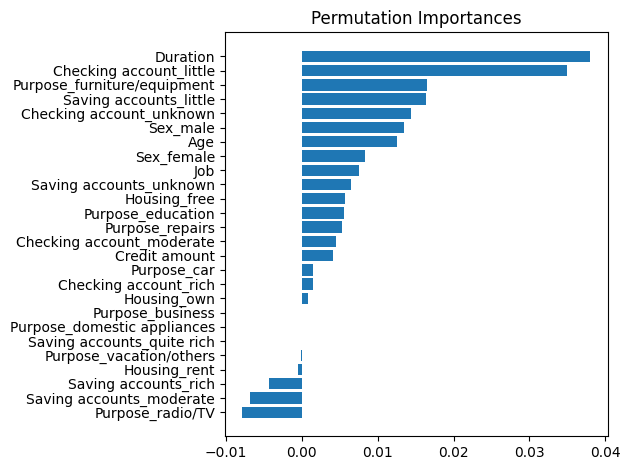

In [60]:
# Compute permutation importances
perm_imp = permutation_importance(model, X_test, y_test,
                                n_repeats=30,
                                random_state=0)

# Plot Permutation Feature Importances
sorted_idx = perm_imp.importances_mean.argsort()
fig, ax = plt.subplots()
ax.barh(X_test.columns[sorted_idx], perm_imp.importances[sorted_idx].mean(axis=1).T)
ax.set_title("Permutation Importances")
fig.tight_layout()
plt.show()

**Most important features:**

* Duration (loan duration): ranks the highest in importance, indicating that this feature has the strongest impact on credit risk prediction in the model. Longer loan durations generally indicate higher risk, which is consistent with common sense in credit risk assessment.

* Checking account_little: This feature also has high importance in the model. A checking account with a low balance could mean that the customer has less financial liquidity, thus increasing the risk of default.

* Purpose_furniture/equipment (Purpose of loan: furniture/equipment): this is a specific category within the purpose of the loan, which the model treats as a factor that has a significant impact on the prediction of credit risk. This may be due to the higher repayment risk associated with this type of loan.

* The bottom of the graph shows features with near-zero or even negative significance, such as Purpose_radio/TV (loan purpose: radio/TV), Saving accounts_rich (saving accounts with rich balances), and Housing_rent (housing rental). These features have a very limited contribution to the model's predictions and may even negatively affect the predictions (i.e., mislead the model's judgment) in some cases.

# Differences between PDP and ALE plots and the impact of feature correlation exploration on results
The differences between the PDP and the ALE Plot in the interpretation of credit risk models are mainly in the treatment of feature correlation and its capture of local effects.The PDP shows the global average impact of features, but in the presence of high correlation of features can be misleading because it assumes that features are independent, leading to unrealistic combinations and impact biases. ALE, on the other hand, eliminates this influence through cumulative local effects, is suitable for revealing the nonlinear and interactive effects of features, and more accurately reflects the true influence of features on model predictions. In the analysis of features such as Age, Credit Amount, and Duration, ALE plots reveal more accurate local effects and nonlinear relationships, while PDP provides a global overview of the impact of these features. The importance of feature correlation exploration is that it can help identify potential biases in the PDP and emphasize the robustness of ALE in dealing with correlated features, thus enhancing the accuracy of model interpretation. In addition, Permutation Importance plots further validate the most important features in the model, demonstrating the critical role of loan duration and account status in risk prediction.

# Reference
1. AIPI-590-XAI. “Duke-Ai-Xai/Explainable-Ml-Example-Notebooks/Global_explanations.Ipynb at Main · AIPI-590-Xai/Duke-Ai-Xai.” GitHub, https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/explainable-ml-example-notebooks/global_explanations.ipynb Accessed 17 Oct. 2024.
2. AIPI-590-XAI. “Duke-Ai-Xai/Explainable-Ml-Example-Notebooks/Local_explanations.Ipynb at Main · AIPI-590-Xai/Duke-Ai-Xai.” GitHub,https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/explainable-ml-example-notebooks/local_explanations.ipynb Accessed 17 Oct. 2024.
3. Ferreira, Leonardo. “German Credit Risk - with Target.” Kaggle, 2018, www.kaggle.com/datasets/kabure/german-credit-data-with-risk.
4. Chatgpt. Explanation of Python code for models
